In [131]:
import sys

# Set the sys path to the main directory of the project
MAIN_DICT = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability"
sys.path.append(MAIN_DICT)

In [132]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils.load import load_data
from utils.params import set_param


# Params for downsampling (specific to the dataset)
WINDOW = int(1e2) # use 1e2
STEP = int(1e2) # use 1e2

# Number of timesteps to display when rendering graphs
SECONDS_TO_DISPLAY = 200

In [133]:
# exp = 'b726'
# exp = 'b698'
# exp = 'i417'
# exp = 'p4679'
exp = "p4581"
# exp = 'cascadia'
# exp = 'sim_b726'
# exp = 'sim_b698'
# exp = 'sim_i417'

params = set_param(exp)

dirs = {"main": MAIN_DICT}
dirs["data"] = dirs["main"] + "/data/" + params["dir_data"]

X, _, t, _, _ = load_data(exp, dirs, params)

# Put the detrended shear stress (X) and time (t) into a pandas dataframe allows
# us to work with it more easily and carry out downsampling

# In numpy, the shape of an array is a tuple that gives the size of each 
# dimension. The shape `(200010, 1)` means that the array `X` is a 2D array with
# 200010 rows and 1 column. The shape `(200010,)` means that the array `t` is a 
# 1D array with 200010 elements. The trailing comma is used to indicate that 
# this is a tuple with one element. In other words, `t` is a 1D array (like a 
# list), while `X` is a 2D array (like a list of lists, where each inner list 
# has only one element).

print(X.shape)
print(t.shape)

# `t.reshape(-1, 1)` is reshaping the `t` array. The `-1` in reshape function is
# a placeholder for "figure out what the dimension should be based on the length
# of the array and the other dimensions". The `1` means we want `t` to have one
# column. So, `t.reshape(-1, 1)` is reshaping `t` to have one column and as many
# rows as needed to accommodate the data.

# We need to reshape `t` because `np.hstack` requires the arrays of the same 
# dimensions.

# `np.hstack` horizontally stacks multiple arrays. In this case, it's stacking 
# the arrays `X` and `t.reshape(-1, 1)` side by side. The result is a single 2D 
# array where the first columns are from `X` and the last column is from `t`.

# The resulting 2D array is then turned into a pandas DataFrame, which is a 2D 
# labeled data structure with columns of potentially different types.
ts_data = pd.DataFrame(np.hstack((X, t.reshape(-1, 1))), columns=["X", "t"])

ts_data.head()

(200010, 1)
(200010,)


,X,t
0,1.29911,0.000
1,1.29903,0.001
2,1.29853,0.002
3,1.29871,0.003
4,1.29854,0.004


Sample rate: 999.9950002499876 Hz


Text(0.5, 1.0, 'De-trended? shear stress vs time')

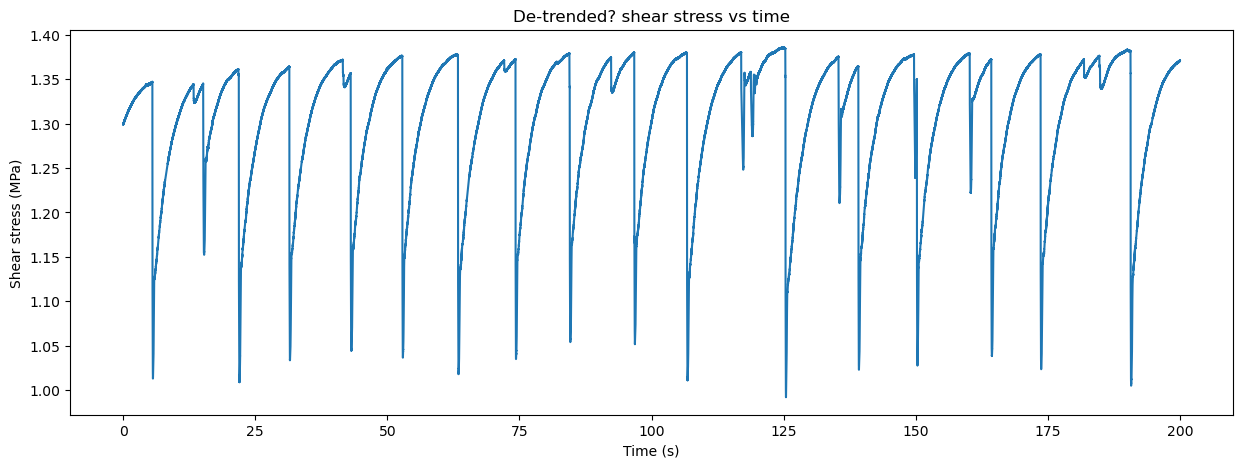

In [134]:
# Compute the sample rate from the time data
sample_rate = 1 / np.mean(np.diff(ts_data["t"]))
print("Sample rate:", sample_rate, "Hz")

# Sample rate as an interger (round to nearest integer)
sample_rate = int(np.round(sample_rate))

segment_in_sec = sample_rate * SECONDS_TO_DISPLAY

plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], ts_data["X"][:segment_in_sec])
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
# FIXME: Has this data now not been de-trended?
plt.title("De-trended? shear stress vs time")

# Not plotting derivative and log derivative for now as signal is too noisy at 
# this stage

Sample rate: 9.999950002499878 Hz


Text(0.5, 1.0, 'De-noised de-trended? shear stress vs time')

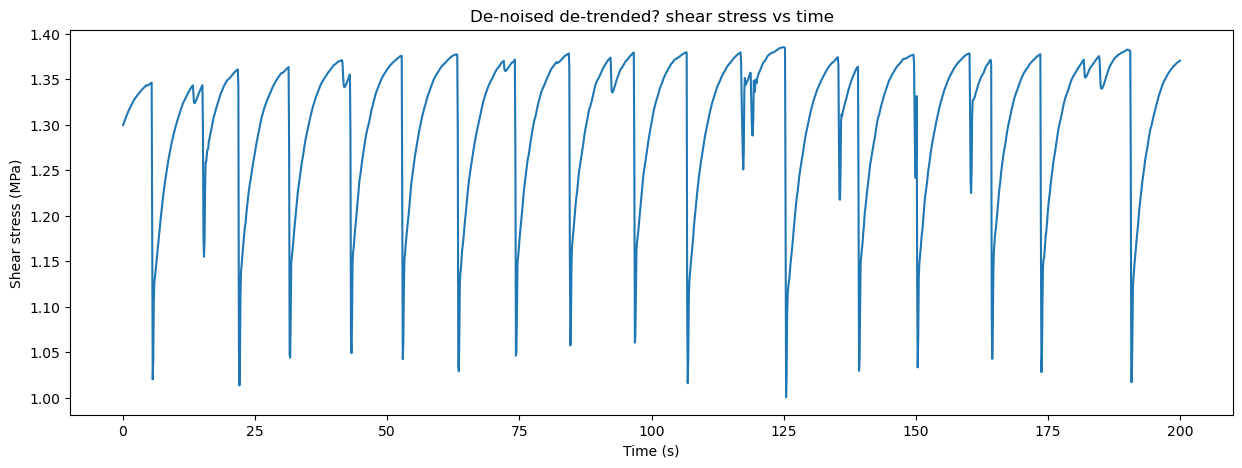

In [135]:
# Downsample to remove noise (smoothing) and make forecasting easier (less 
# points to predict)

# Apply a rolling window function with a specific window size and step size, 
# then calculate the mean for each window. This is a way of downsampling the 
# data, reducing its size and smoothing out short-term fluctuations.
# The dropna() function is used to remove any resulting missing values.
ts_data = ts_data.rolling(window=WINDOW, step=STEP).mean().dropna()

# Reset the index of the DataFrame. The 'drop=True' argument is used to avoid 
# the old index being added as a column.
ts_data = ts_data.reset_index(drop=True)

# TODO: Wrap this in a util function
# Compute the sample rate from the time data post downsampling
sample_rate = 1 / np.mean(np.diff(ts_data["t"]))
print("Sample rate:", sample_rate, "Hz")

# Sample rate as an interger rounded to nearest integer
sample_rate = int(np.round(sample_rate))

segment_in_sec = sample_rate * SECONDS_TO_DISPLAY

# Plot the downsampled data
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], ts_data["X"][:segment_in_sec])
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("De-noised de-trended? shear stress vs time")

Text(0.5, 1.0, 'Rate of change of de-noised de-trended shear stress vs time')

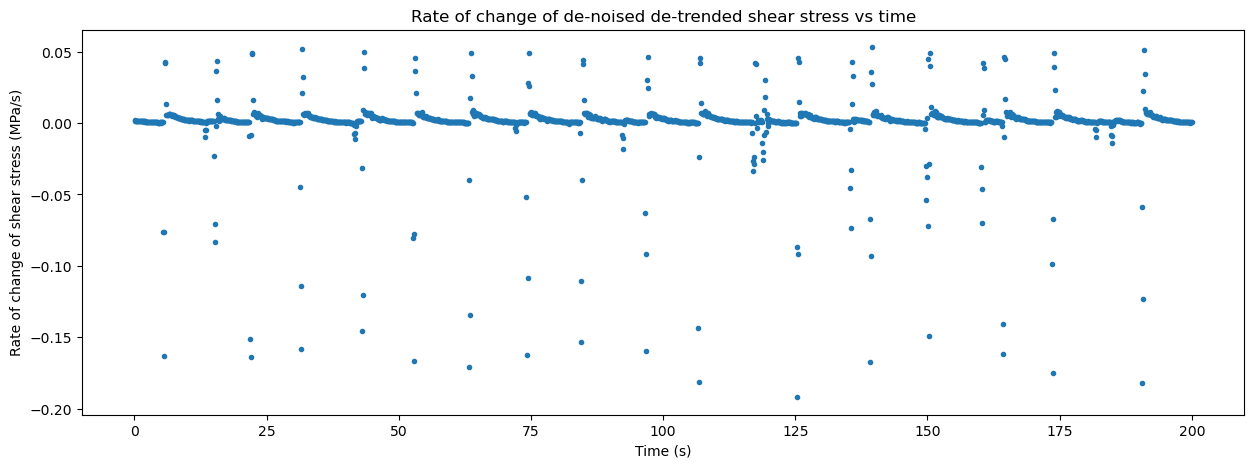

In [136]:
# Plot the derivative of the data (e.g. the rate of change of shear stress)
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], np.gradient(ts_data["X"][:segment_in_sec]), ".")
plt.xlabel("Time (s)")
plt.ylabel("Rate of change of shear stress (MPa/s)")
plt.title("Rate of change of de-noised de-trended shear stress vs time")

Text(0.5, 1.0, 'Log rate of change of de-noised de-trended shear stress vs time')

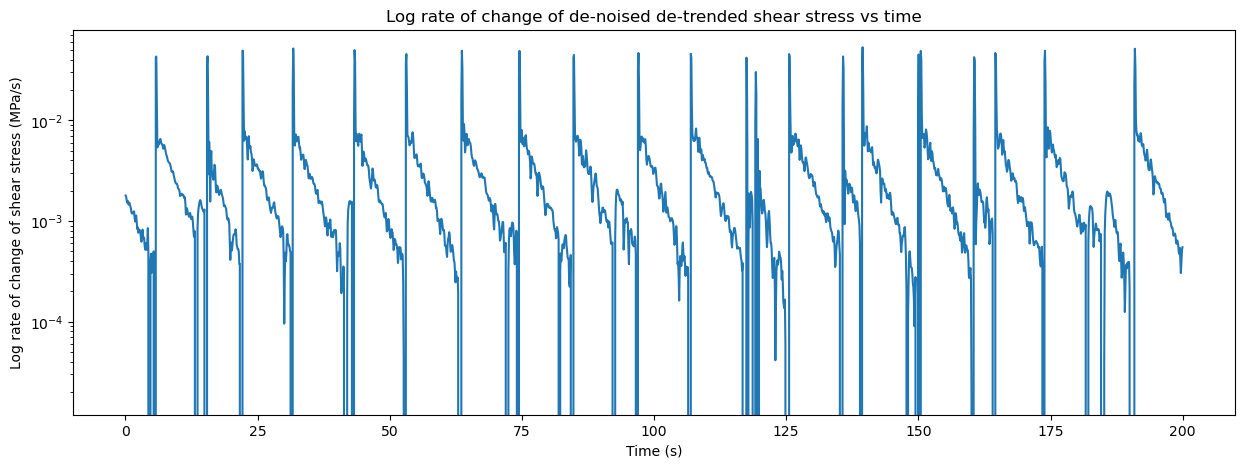

In [137]:
# Do a similar gradient plot but with a log scale (as in the above plot it is 
# tricky to see the rate of change of shear stress duringt the stick phase)
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], np.gradient(ts_data["X"][:segment_in_sec]))
plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("Log rate of change of shear stress (MPa/s)")
plt.title("Log rate of change of de-noised de-trended shear stress vs time")

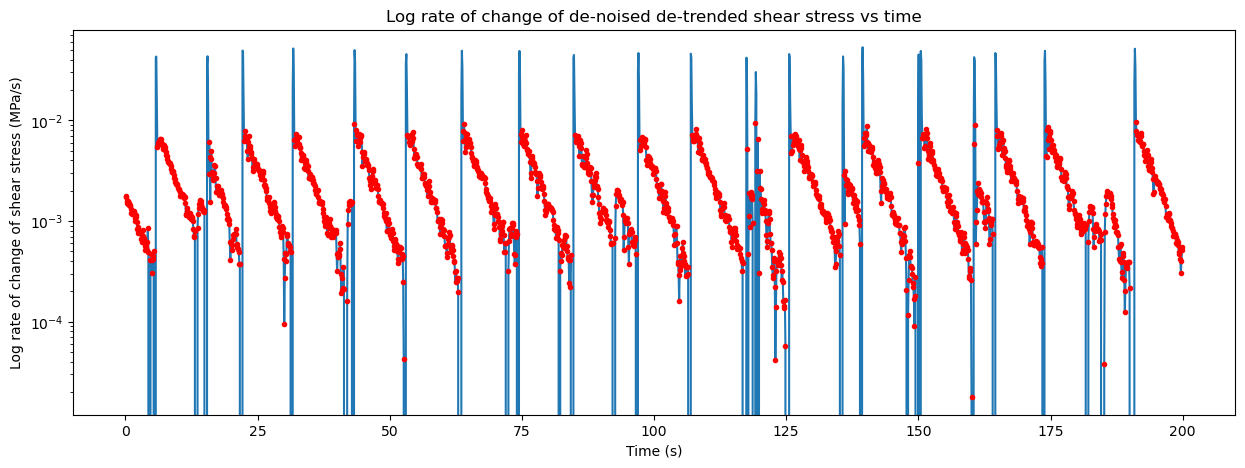

In [138]:
# Isolate and highlight the points where the rate of changes of shear stress
# gradually decreases toward 0 (i.e. the stick phase going towards the turning 
# point)

# Query the indexes where the log rate of change is between 10^-2 and 10^-3
# FIXME: don't understand why this works
# indexes = np.where((np.log10(np.abs(np.gradient(ts_data["X"])))) < -2)[0]

# plt.figure(figsize=(15, 5))
# plt.plot(ts_data["t"], np.gradient(ts_data["X"]))
# plt.plot(ts_data["t"][indexes], np.gradient(ts_data["X"][indexes]), 'r.')
# plt.xlabel("Time (s)")
# plt.ylabel("Log rate of change of shear stress (MPa/s)")
# plt.title("Log rate of change of de-noised de-trended shear stress vs time")
# plt.yscale("log")

# Calculate the gradient and select indexes
gradient = np.gradient(ts_data["X"])
indexes = np.where((np.log10(np.abs(gradient))) < -2)[0]

# Limit the number of data points to 500
max_index = min(segment_in_sec, len(ts_data["t"]))
indexes = indexes[indexes < max_index]
gradient = gradient[:max_index]
time = ts_data["t"][:max_index]

# Plot the data
plt.figure(figsize=(15, 5))
plt.plot(time, gradient)
plt.plot(time[indexes], gradient[indexes], 'r.')
plt.xlabel("Time (s)")
plt.ylabel("Log rate of change of shear stress (MPa/s)")
plt.title("Log rate of change of de-noised de-trended shear stress vs time")
plt.yscale("log")
plt.show()

Number of buckets: 23


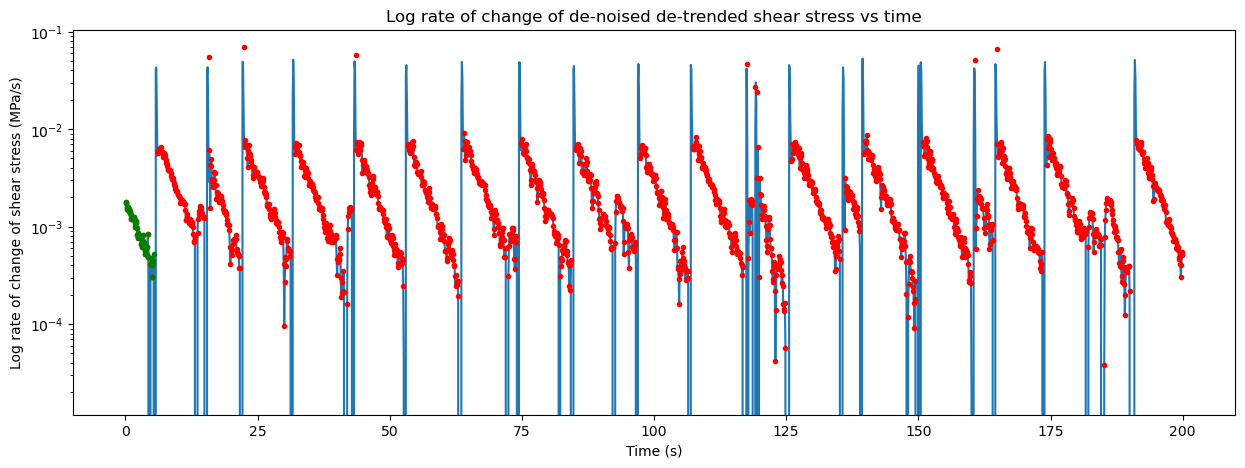

In [146]:
# Loop through the indexes, grouping points into buckets. start a new bucket if
# the difference between the current point and the previous point is greater 
# than 1. Otherwise, add the current point to the current bucket.
buckets = []
for i in indexes:
    if len(buckets) == 0 or i - buckets[-1][-1] > 1:
        buckets.append([i])
    else:
        buckets[-1].append(i)

# Remove buckets with less than 10 points
buckets = [bucket for bucket in buckets if len(bucket) > 20]
# Replace negative indexes with 0
buckets = [[max(0, i) for i in bucket] for bucket in buckets]
print("Number of buckets:", len(buckets))

# Plot the indexes in the first bucket on the log rate of change plot
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], np.gradient(ts_data["X"][:segment_in_sec]))
plt.plot(ts_data["t"][indexes], np.gradient(ts_data["X"][indexes]), 'r.')
# Ployt the indexes in the first bucket
plt.plot(ts_data["t"][buckets[0]], np.gradient(ts_data["X"][buckets[0]]), 'g.')
plt.xlabel("Time (s)")
plt.ylabel("Log rate of change of shear stress (MPa/s)")
plt.title("Log rate of change of de-noised de-trended shear stress vs time")
plt.yscale("log")

Text(0.5, 1.0, 'Log rate of change of de-noised de-trended shear stress vs time')

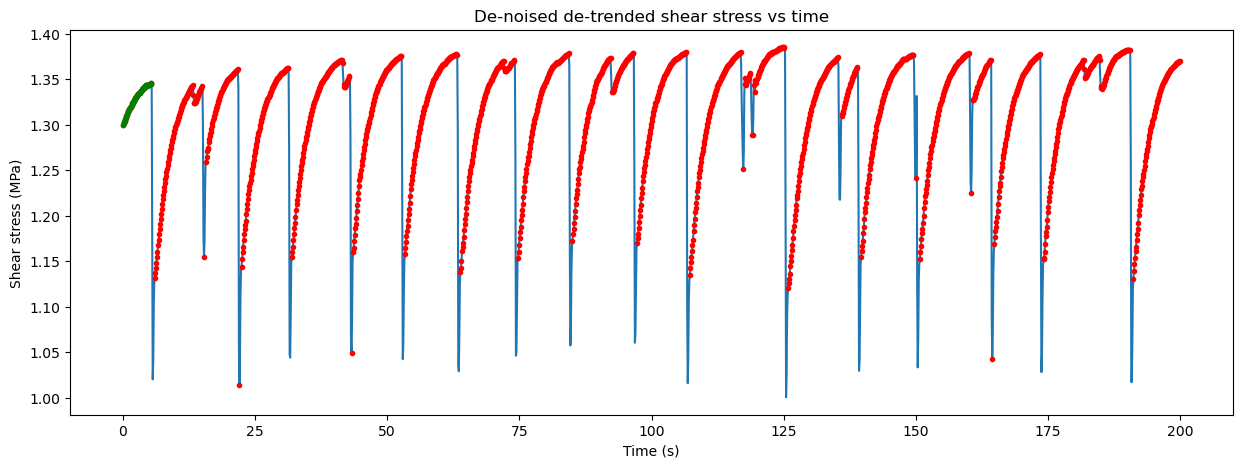

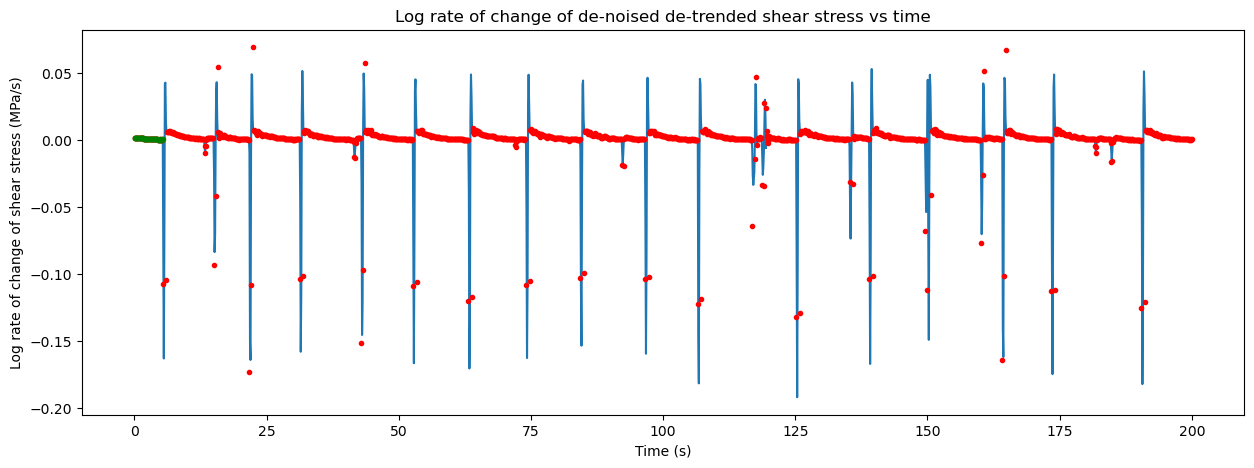

In [147]:
# Plot what this looks like on the normal plot
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], ts_data["X"][:segment_in_sec])
plt.plot(ts_data["t"][indexes], ts_data["X"][indexes], 'r.')
plt.plot(ts_data["t"][buckets[0]], ts_data["X"][buckets[0]], 'g.')
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("De-noised de-trended shear stress vs time")

# Plot what this looks like on the rate of change plot
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], np.gradient(ts_data["X"][:segment_in_sec]))
plt.plot(ts_data["t"][indexes], np.gradient(ts_data["X"][indexes]), 'r.')
plt.plot(ts_data["t"][buckets[0]], np.gradient(ts_data["X"][buckets[0]]), 'g.')
plt.xlabel("Time (s)")
plt.ylabel("Log rate of change of shear stress (MPa/s)")
plt.title("Log rate of change of de-noised de-trended shear stress vs time")

Text(0.5, 1.0, 'De-noised de-trended shear stress vs time')

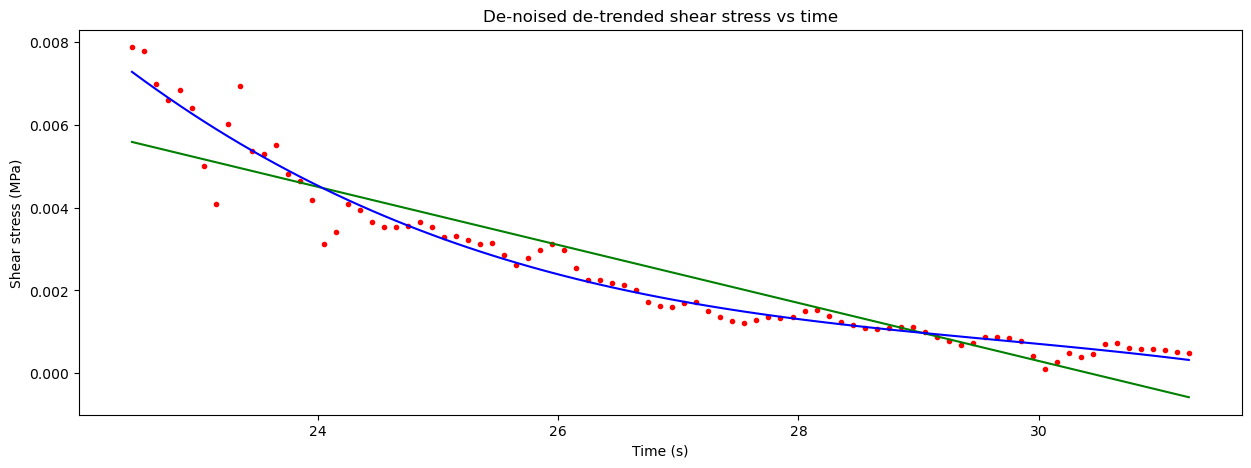

In [148]:
bucket = buckets[3]

# Fit a line to the data in the first bucket
f = np.poly1d(np.polyfit(ts_data["t"][bucket], np.gradient(ts_data["X"][bucket]), 1))

# Fit a curve to the data in the first bucket
p = np.poly1d(np.polyfit(ts_data["t"][bucket], np.gradient(ts_data["X"][bucket]), 3))

# Plot the indexes in the first bucket
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][bucket], np.gradient(ts_data["X"][bucket]), 'r.')
# Plot the line of best fit
plt.plot(ts_data["t"][bucket], f(ts_data["t"][bucket]), 'g')
# Plot the curve of best fit
plt.plot(ts_data["t"][bucket], p(ts_data["t"][bucket]), 'b')
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")
plt.title("De-noised de-trended shear stress vs time")

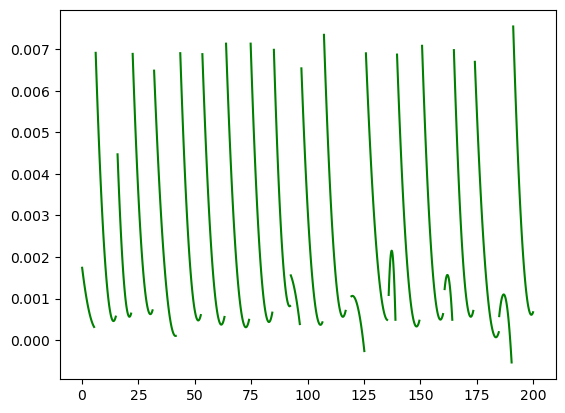

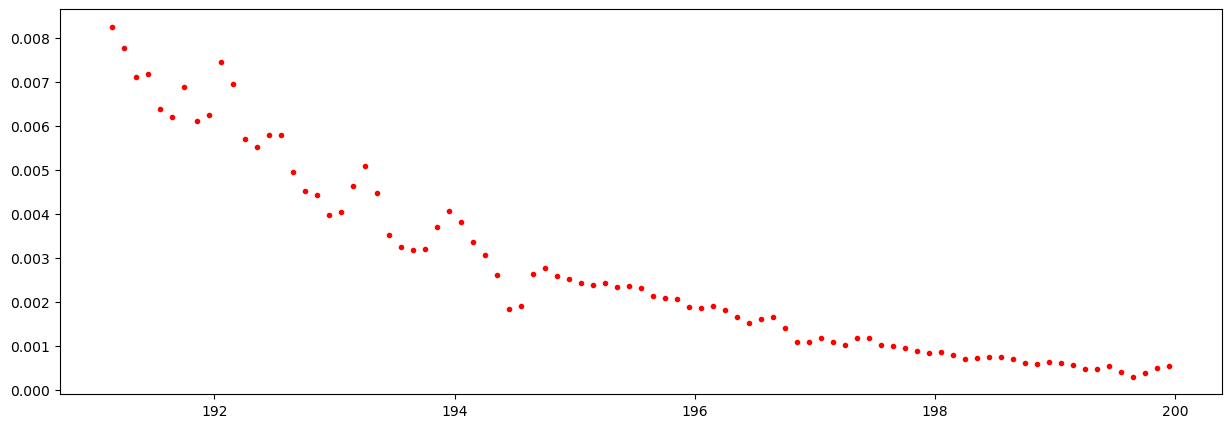

In [152]:
# This is function is only calculated based on one bucket, fit a line to the
# data across all the buckets

# Start by making an initial fit and then update the fit based on the data in
# each bucket

for bucket in buckets:
    f = np.poly1d(np.polyfit(ts_data["t"][bucket], np.gradient(ts_data["X"][bucket]), 2))

# Take one of the fits that works e.g. the last one

# Use the f function to predict the TTsF (when equal 0) and generate a MTtF plot
# TTsF = 0 when the rate of change of shear stress is 0 i.e. f = 0
# y = at^2 + bt + c
# t = (-b + sqrt(b^2 - 4ac)) / 2a
def predict_TTsF(f):
    a, b, c = f.coefficients
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)




In [ ]:
# Fit a function to the points in the first bucket (make it an exponential)
f = np.poly1d(np.polyfit(ts_data["t"][bucket], np.gradient(ts_data["X"][bucket]), 1))
plt.plot(ts_data["t"][bucket], f(ts_data["t"][bucket]), 'r-')

# What is the gradient and intercept of the function?
print("Gradient:", f.c[0])
print("Intercept:", f.c[1])

def predict_failure_time(f, current_rate_of_change_of_shear_stress):
    # If the rate of change of shear stress is positive, stick phase, else output -1
    # y = mx + c
    # x = (y - c) / m
    if current_rate_of_change_of_shear_stress < 0:
        return 0.0
    x = (current_rate_of_change_of_shear_stress - f.c[1]) / f.c[0]
    print("x:", x)
    # How long between now and when the fault slips? (x and the x-intercept)
    x_intercept = f.r
    print("x_intercept:", x_intercept)
    return x_intercept - x

print("Predicted failure time:", predict_failure_time(f, 0.00125))

# for each value in the gradient, predict the failure time
failure_times = []
for i in np.gradient(ts_data["X"]):
    failure_times.append(predict_failure_time(f, i))

print("Number of failure times:", len(failure_times))
print("Number of timesteps:", len(ts_data["t"]))

# Plot the failure times
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], failure_times[:segment_in_sec])
plt.xlabel("Time (s)")
plt.ylabel("Failure time (s)")
plt.title("Predicted failure time vs time")

# Now we have a function for the rate of change of shear stress during the stick phase
# We know that the turning point is when the rate of change of shear stress is 0 (near zero)
# That is when the fault slips
# We can use the function to find the time when the rate of change of shear stress will be 0 to predict when the fault will slip

# Algorithm:
# If the signal is in the stick phase, use the function to predict when the fault will slip in seconds
# If the signal is in the slip phase, output -1


# When the log rate of change is approximately 10^-3, the system becomes 
# unstable. 
# Get all the timesteps where the log rate of change is approximately 10^-3

gradient = np.gradient(ts_data["X"])
log_gradient = np.log10(np.abs(gradient))

# Get the indices of the timesteps where the log rate of change is around 10^-3
unstable_indices = np.where(np.abs(log_gradient) > 2)[0]

# Only keep the unstable indices that are preceded by a positive gradient (build of shear stress)
unstable_indices = unstable_indices[gradient[unstable_indices - 1] > 0]

# Find the rate of change of the derivative of the shear stress (i.e. the
# second derivative of shear stress) and plot it
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"][:segment_in_sec], np.gradient(gradient[:segment_in_sec]))
plt.xlabel("Time (s)")
plt.ylabel("Rate of change of rate of change of shear stress (MPa/s^2)")
plt.title("Rate of change of rate of change of de-noised de-trended shear stress vs time")

# Plot the unstable indices on a shear stress vs time plot
plt.figure(figsize=(15, 5))
plt.plot(ts_data["t"], ts_data["X"])
plt.plot(ts_data["t"][unstable_indices], ts_data["X"][unstable_indices], 'r.')
plt.xlabel("Time (s)")
plt.ylabel("Shear stress (MPa)")